Read in required libraries

In [1]:
# data analysis
import xarray as xr
import numpy as np
import pandas as pd
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean as cmo

Import Dask

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44775,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:38809,Total threads: 4
Dashboard: /proxy/36163/status,Memory: 45.00 GiB
Nanny: tcp://127.0.0.1:41435,


## Estimate % of meltwater forcing from Golledge et al. (2019)

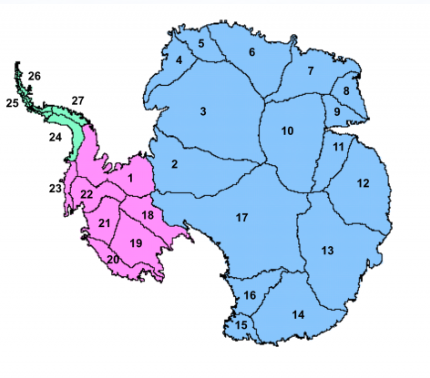
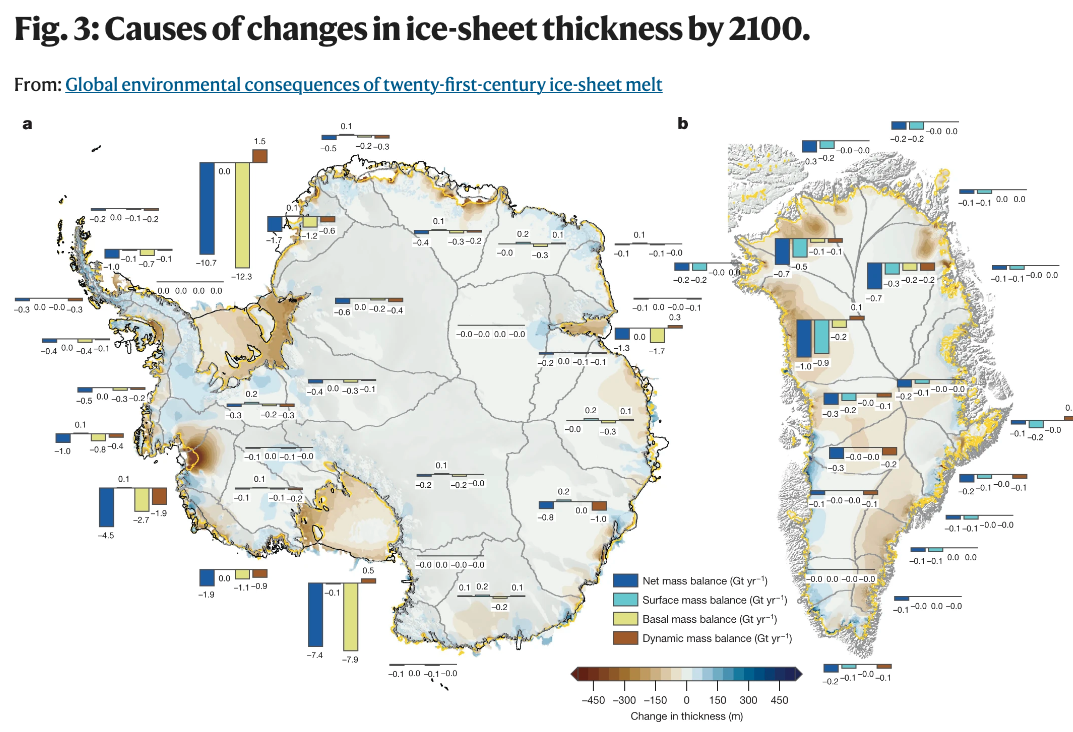

Work out Golledge freshwater distribution based on drainage basin. 

In [3]:
net_Gt_yr = -0.5 + -0.4 + -0.0 + -0.1 + -0.1 + -1.3 + -0.0 + -0.2 + -0.0 + -0.8 + 0.1 + -0.0 + -0.2 + -0.1 + -7.4 + -1.9 + -0.1 + -0.1 + -4.5 + -1.0 + -0.5 + -0.4 + -0.3 + -0.2 + -1.0 + 0.0 + -0.3 + -0.4 + -0.6 + -10.7 + -1.7
print(net_Gt_yr)

-34.7


| Basin | Net Mass balance (GT / yr) | % of total Antarctic Net Mass Balance |
| --- | --- | --- |
| 1 | -0.3 | 0.865 |
| 2 | -0.4 | 1.153 |
| 3 | -0.6 | 1.729 |
| 4 | -1.7 | 4.899 |
| 5 | -0.5 | 1.441 |
| 6 | -0.4 | 1.153 |
| 7 | -0.0 | 0 |
| 8 | -0.1 | 0.288 |
| 9 | -0.1 | 0.288 |
| 10 | -0.0 | 0 |
| 11 | -0.2 | 0.576 |
| 12 | -0.0 | 0 |
| 13 | -0.8 | 2.305 |
| 14 | 0.1 | -0.2881 |
| 15 | -0.1 | 0.288 |
| 16 | -0.0 | 0 |
| 17 | -0.2 | 0.576 |
| 18 | -0.1 | 0.288 |
| 19 | -0.1 | 0.288 |
| 20 | -1.9 | 5.476 |
| 21 | -4.5 | 12.968 |
| 22 | -1.0 | 2.882 |
| 23 | -0.5 | 1.441 |
| 24 | -0.4 | 1.153 |
| 25 | -0.3 | 0.865 |
| 26 | -1.2 | 3.458 |
| 27 | 0.0 | 0 |
| Ross IS | -7.4 | 21.326 |
| Ronne-Filchner IS| -10.7 | 30.836 |
| Amery IS| -1.3 | 3.746 |

Now based on drainage regions into ocean, and define lat and lon bounds based on drainge basins below. 

| Region/Basin | Basins that drain into it | Lon bounds [W-E]|  Lat bounds [S-N]|
| --- | --- | --- | --- |
| Ronne-Filchner IS | 1 + 2 + 3 + RFIS | [-62, -35] | [None, -74.5] |
| 4 | 4 | [-35, -10] |--- |
| 5 | 5 | [-10, 2.5] |--- |
| 6 | 6 | [2.5, 34] |--- |
| 7 | 7 | [34, 56] |--- |
| 8 | 8 | [56, 69] |--- |
| Amery IS | 9 + 10 + 11 + AS | [69, 74] |--- |
| 12 | 12 | [74, -255] |--- |
| 13 | 13 | [-255, -230] |--- |
| 14 | 14 | [-230, -202] |--- |
| 15 | 15 | [-202, -187] |[-74, -68] |
| 16 | 16 | [-200, -194] | [-78 , -74] |
| Ross IS | 17 + 18 + 19 + RS | [-194, -158] | [ None , -76] |
| 20 | 20 | [-158 , -115] |--- |
| Amundsen Sea embayment |  21 + 22 | [ -115, -100] | [ None , -73.5] |
| 23 | 23 | [-105, -81 ] | [-73.5, None ] |
| 24 | 24 | [-81 , -68.5] | [ None , -68] |
| 25 | 25 | [-68.5 , -57.5] | [-69.5, ] |
| 26 | 26 | [?,?] [-62, -54] | [ -69.5 , -63.5] |
| 27 | 27 | [-65, -57] | [-74.5, -69.5] |

Read in drainage basins. 

In [4]:
ant_basins = pd.read_csv('ant_full_drainage_system_polygons.csv', sep=',', header=0)
ant_basins

,lat,lon,basin_id
0,-76.994317,-50.368529,1
1,-76.995042,-50.372416,1
2,-76.995917,-50.369197,1
3,-76.996792,-50.365977,1
4,-76.997667,-50.362756,1
...,...,...,...
901317,-69.704795,-60.878129,27
901318,-69.705770,-60.876564,27
901319,-69.706745,-60.875000,27
901320,-69.707720,-60.873434,27


Plot stereo map of Antarctica and scatter plot basins on this. 

In [29]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht.sel(yt_ocean = slice(-90,-32))
land_mask = (ht*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
land_mask_lat = land_mask_masked.yt_ocean.values
land_mask_lat[0]=-90
yt_ocean, xt_ocean = ht.yt_ocean.values, ht.xt_ocean.values
yt_ocean[0]=-90

# define circle 
def create_circle():
    import matplotlib.path as mpath
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    return circle

def plot_box(lon1, lon2,lat1, lat2, color):
    if lon2 == None:
        lon2 = 360.
    if lat1 == None:
        lat1 = -79.
    if lat2 == None:
        lat2 = -62.
    plt.plot([lon1,lon1],[lat1,lat2],c=color, transform = ccrs.PlateCarree())
    plt.plot([lon2,lon2],[lat1,lat2],c=color, transform = ccrs.PlateCarree())
    plt.plot([lon1,lon2],[lat1,lat1],c=color, transform = ccrs.PlateCarree())
    plt.plot([lon1,lon2],[lat2,lat2],c=color, transform = ccrs.PlateCarree())

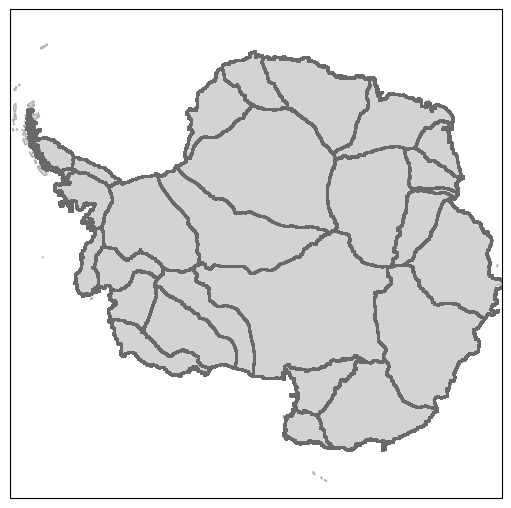

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(5,5))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
axes = fig.add_subplot(spec[:, :], projection=ccrs.SouthPolarStereo(central_longitude=0))

axes.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
axes.contour(ht.xt_ocean, land_mask_lat, land_mask, [0,1], zorder=2,
                 colors='darkgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())

#scatter plot drainage basins
for b_id in np.arange(1,28,1):
    lat = ant_basins[ant_basins.basin_id == b_id].lat.values
    lon = ant_basins[ant_basins.basin_id == b_id].lon.values
    axes.scatter(lon, lat, s=2, marker='.', c='dimgrey', zorder=3, transform = ccrs.PlateCarree())

axes.set_extent([-280, 80, -80, -65], crs=ccrs.PlateCarree())
plt.show()

Zoom in on specific regions

5


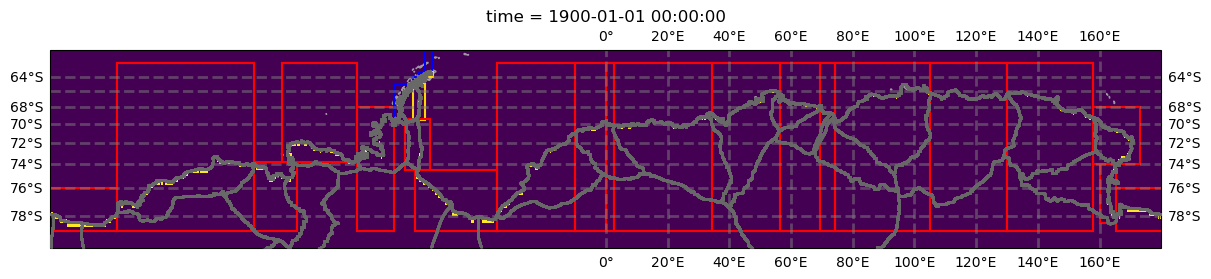

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(12,5))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
axes = fig.add_subplot(spec[:, :], projection=ccrs.Mercator(central_longitude=0))

axes.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
axes.contour(ht.xt_ocean, land_mask_lat, land_mask, [0,1], zorder=2,
                 colors='darkgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())

#scatter plot drainage basins
for b_id in np.arange(1,28,1):
    lat = ant_basins[ant_basins.basin_id == b_id].lat.values
    lon = ant_basins[ant_basins.basin_id == b_id].lon.values
    axes.scatter(lon, lat, s=2, marker='.', c='dimgrey', zorder=3, transform = ccrs.PlateCarree())

for key in bounds:
    l,r,b,t = bounds[key]
    if key == '5':
        print('5')
        plot_box(l,r,b,t,'r')
        plot_box(0.,2.5,b,t,'r')
    elif key == '25':
        plot_box(291.5,297.5,-69.5,-65,'b')
        plot_box(297.5,299.5,-65,-64,'b')
        plot_box(299.5,301.5,-64,-63.5,'b')
        plot_box(301.5,303.5,-63.5,-60,'b')
    elif key == '26':
        plot_box(302,304,-64,-63.4,'gold')
        plot_box(301,302,-64,-63.6,'gold')
        plot_box(299,301,-65,-64,'gold')
        plot_box(297.5,301.5,-69.5,-65,'gold')
    else:
        plot_box(l,r,b,t,'r')

runoff.friver.isel(time=0).plot(ax=axes, vmax = 0.00001, transform = ccrs.PlateCarree(), add_colorbar=False)


axes.set_extent([0, 360, -80, -60], crs=ccrs.PlateCarree())
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(0,360,20))
gl.ylocator = mticker.FixedLocator(np.arange(-80,-62,2))
plt.show()
plt.show()

Regions checked: 1, 

5


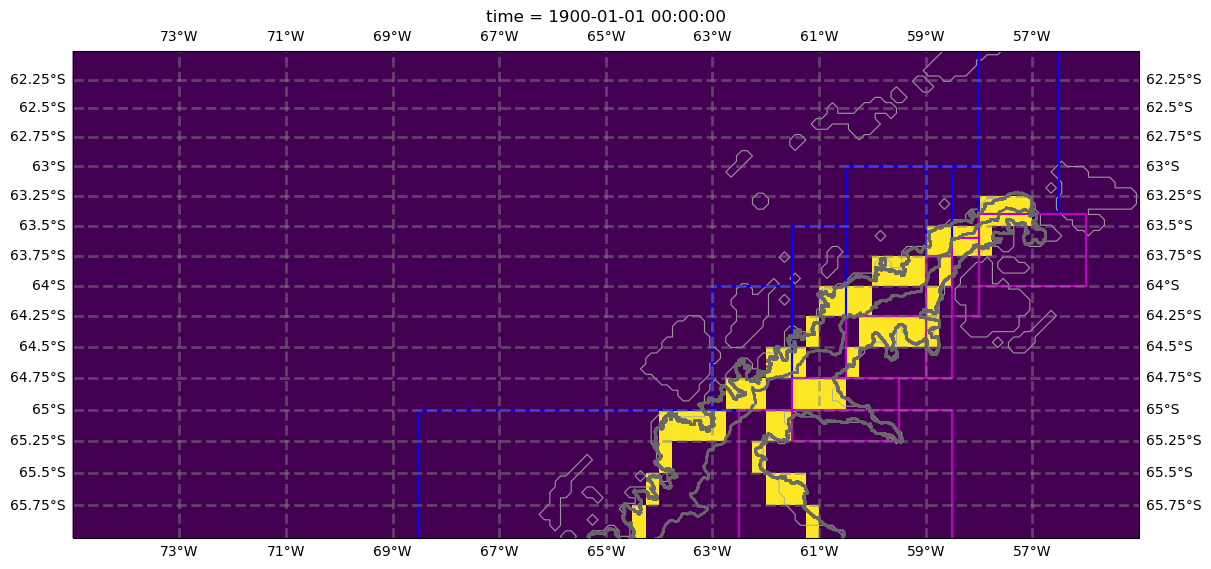

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(12,8))
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
axes = fig.add_subplot(spec[:, :], projection=ccrs.Mercator(central_longitude=0))

axes.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
axes.contour(ht.xt_ocean, land_mask_lat, land_mask, [0,1], zorder=2,
                 colors='darkgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())

#scatter plot drainage basins
for b_id in np.arange(1,28,1):
    lat = ant_basins[ant_basins.basin_id == b_id].lat.values
    lon = ant_basins[ant_basins.basin_id == b_id].lon.values
    axes.scatter(lon, lat, s=2, marker='.', c='dimgrey', zorder=3, transform = ccrs.PlateCarree())

for key in bounds:
    l,r,b,t = bounds[key]
    if key == '5':
        print('5')
        plot_box(l,r,b,t,'r')
        plot_box(0.,2.5,b,t,'r')
    if key == '23':
        plot_box(l,r-5.3,b,t,'r')
        plot_box(r-5.3,r,b-1,t,'r')
    elif key == '25':
        plot_box(291.5,297.5,-69.5,-65,'b')
        plot_box(297.,298.5,-65,-64,'b')
        plot_box(298.5,299.5,-64.75,-63.5,'b')
        plot_box(299.5,301.,-64.25,-63,'b')
        plot_box(301.,301.5,-63.75,-63,'b')
        plot_box(301.5,302.,-63.6,-63,'b')
        plot_box(302.,303.5,-63.4,-60,'b')
    elif key == '26':
        # plot_box(302,304,-63.6,-63.4,'m')
        # plot_box(301.5,303,-63.75,-63.6,'m')
        # plot_box(301,302,-64.25,-63.75,'m')
        # plot_box(299.5,301.5,-64.75,-64.25,'m')
        # plot_box(298.5,301.,-65,-64.75,'m')
        # plot_box(297.5,301.5,-69.4,-65,'m')

        plot_box(302.,304,-64.,-63.4,'m')
        plot_box(301.5,302.,-64.25,-63.6,'m')
        plot_box(301,301.5,-64.75,-63.75,'m')
        plot_box(299.5,301.,-64.75,-64.25,'m')
        plot_box(298.5,300.5,-65.25,-64.75,'m')
        plot_box(297.5,301.5,-69.4,-65,'m')

        #l1,l2,l3,l4,l5,l6 = 301.5, 301.5, 301., 299.5, 298.5, 297.5
        #r1,r2,r3,r4,r5,r6 = 304., 303., 302., 301.5, 301., 301.5
        #b1,b2,b3,b4,b5,b6 = -63.75, -63.75, -64.25, -64.75, -65., -69.4
        #t1,t2,t3,t4,t5,t6 = -63.4, -63.6, -65.75, -64.25, -64.75, -65

    
    else:
        plot_box(l,r,b,t,'r')

runoff.friver.isel(time=0).plot(ax=axes, vmax = 0.00001, transform = ccrs.PlateCarree(), add_colorbar=False)


axes.set_extent([-75, -55, -66, -62], crs=ccrs.PlateCarree())
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-75, -55, 2))
gl.ylocator = mticker.FixedLocator(np.arange(-66,-62,0.25))
plt.show()
plt.show()

Now define dictionary of drainage basin bounds and % contribution to meltwater forcing at 2100. 

In [8]:
bounds = {'RFIS': (298., 324.6, None, -74.5),
         'RIS': (165.5, 201.6, None, -76.),
         'AIS': (69.5, 74.4, None, None), 
         '4': (324.6, 350., None, None),
         '5': (350., None, None, None), #(None, 2.5, None, None), 
         '6': (2.5, 34.5, None, None),
         '7': (34.5, 56.5, None, None),
         '8': (56.5, 69.5, None, None),
         '12': (74.4, 105., None, None),
         '13': (105., 130., None, None),
         '14': (130., 158., None, None),
         '15': (158., 173., -74., -68.),
         '16': (160., 165.5, -78.5, -74.),
         '20': (201.6, 245.9, None, None),
         'AS': (245.9, 260., None, -73.75),
         '23': (255., 279.5, -73.75, None),
         '24': (279.5, 291.5, None, -68.),
         '25': (291.5, 302.5, -69.5, None),
         '26': (298., 306., -69.4, -63.5),
         '27': (295., 303, -74.5, -69.4),}

mw_frac = {'RFIS': 0.865+1.153+1.729+30.836,
         'RIS': 0.576+0.288+0.288+21.326,
         'AIS': 0.288+0.+0.576+3.746, 
         '4': 4.899,
         '5': 1.441,
         '6': 1.153,
         '7': 0.,
         '8': 0.288,
         '12': 0.,
         '13': 2.305,
         '14': -0.288,
         '15': 0.288,
         '16': 0.,
         '20': 5.476,
         'AS': 12.968+2.882,
         '23': 1.441,
         '24': 1.153,
         '25': 0.865,
         '26': 3.458,
         '27': 0.,}

# check that meltwater fractions add to 100%
mw_frac.values()
my_list = []
for i in mw_frac.values():
    my_list.append(i)
np.sum(my_list)

100.0

## Now calculate new runoff forcings for SSP245 and SSP585

Read in JRA55-do runoff forcing from control simulation. 

In [9]:
dir = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/V1-3/'
file = 'RYF.runoff_all.1990_1991.nc'
runoff = xr.open_dataset(dir+file)
runoff.friver

<xarray.DataArray 'friver' (time: 365, latitude: 720, longitude: 1440)>
[378432000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Attributes:
    units:          kg/m2/sec
    long_name:      Water flux into sea water from rivers
    standard_name:  water_flux_into_sea_water_from_rivers

Plot this runoff for reference. 

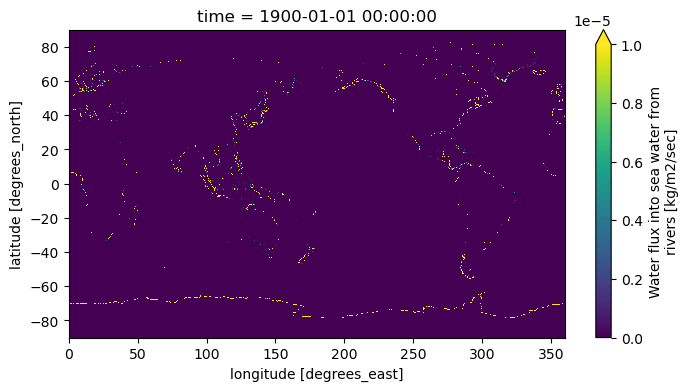

In [12]:
runoff.friver.isel(time=0).plot(figsize=(8,4),vmax = 0.00001)
#plt.ylim([-90,-60])
plt.show()

Plot the Antarctic region only. 

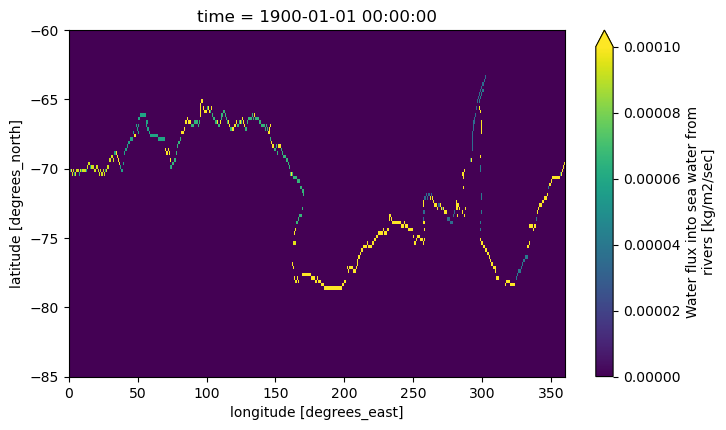

In [13]:
runoff.friver.isel(time=0).plot(figsize=(8,4.5),vmax = 0.0001)
plt.ylim([-85,-60])
plt.show()

Plot longitudinal distribution for the Antarctic region only. 

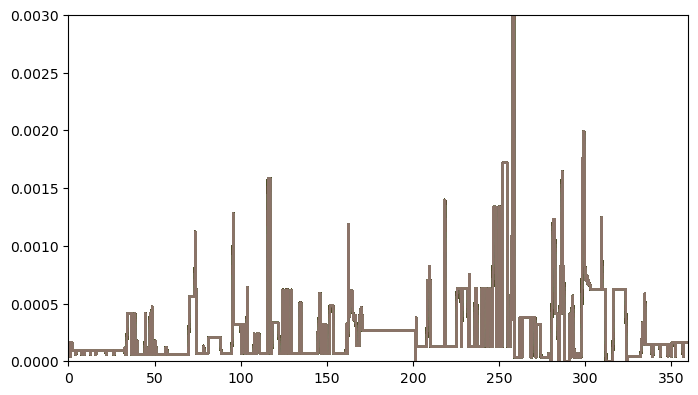

In [14]:
fig = plt.figure(figsize=(8,4.5))
for t in range(365):
    plt.plot(runoff.friver.longitude, runoff.friver.isel(time=t).sel(latitude=slice(None,-60)).sum(dim='latitude'), alpha=0.2)

plt.ylim([0,0.003])
plt.xlim([0,360])
plt.show()

This is constant in time. 

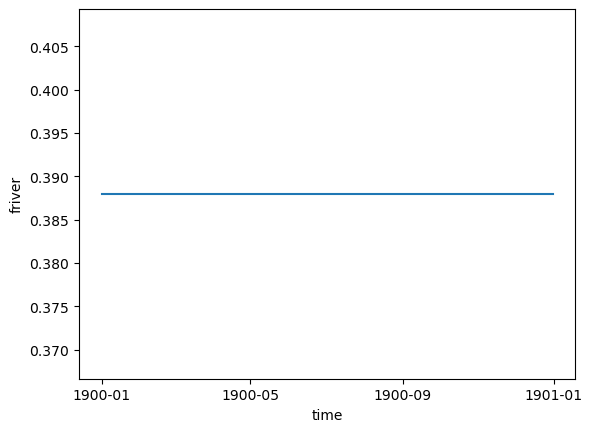

In [15]:
runoff.friver.sel(latitude=slice(None,-60)).sum(dim=['latitude','longitude']).plot()
plt.show()

### Convert runoff to Sverdrups

Units of runoff are $kg/m^2/second$. Projected meltwater fluxes are in Sverdrup. (0.16Sv by 2100 for RCP8.5 and 0.042Sv by 2100 for RCP4.5). So to convert runoff from control into Sverdrup: $(runoff * grid cell area)/\rho_{freshwater}/1,000,000$, where $\rho_{freshwater} = 1000 kg/m^3$

First, calculate grid cell area: 

In [16]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371*1000 # Radius of earth in m. Use 3956 for miles. Determines return value units.
    return c * r

In [17]:
distance_yt = runoff.friver.isel(time=0).isel(latitude = 0).copy(deep=True)
distance_yt = distance_yt.rename('distance_yt')
distance_yt.attrs['units'] = 'm'
distance_yt.attrs['long_name'] = 'distance along grid cell in meridional direction'
distance_yt.attrs['standard_name'] = 'distance along grid cell in meridional direction'
distance_yt

distance_xt = runoff.friver.isel(time=0).isel(longitude = 0).copy(deep=True)
distance_xt = distance_xt.rename('distance_xt')
distance_xt.attrs['units'] = 'm'
distance_xt.attrs['long_name'] = 'distance along grid cell in zonal direction'
distance_xt.attrs['standard_name'] = 'distance along grid cell in zonal direction'

# Grid cell lengths
for j, lat in enumerate(runoff.latitude.values):
    distance_xt[j] = haversine(distance_xt.longitude.values, lat, distance_xt.longitude.values+0.25, lat)
print(distance_xt.values[0:20])

for i, lon in enumerate(runoff.longitude.values):
    distance_yt[i] = haversine(lon, distance_yt.latitude.values, lon, distance_yt.latitude.values + 0.25)
print(distance_yt.values[0:20])

# calculate area [m2]
area = distance_xt*distance_yt

[  60.647327  181.94083   303.23087   424.51514   545.7913    667.0571
  788.3102    909.5483   1030.769    1151.9702   1273.1494   1394.3043
 1515.4329   1636.5323   1757.6008   1878.6357   1999.6349   2120.596
 2241.5168   2362.3948  ]
[27798.732 27798.732 27798.732 27798.732 27798.732 27798.732 27798.732
 27798.732 27798.732 27798.732 27798.732 27798.732 27798.732 27798.732
 27798.732 27798.732 27798.732 27798.732 27798.732 27798.732]


In [18]:
# Now convert runoff to Sverdrup
runoff_sv = runoff.friver*area.values/1000/1000000   #kg/m2/s * m2 = kg/s / rho = m3/s /1,000,000 = Sv
print(runoff_sv.isel(time=-1).sel(latitude=slice(None, -60)).sum().values)
runoff_sv

0.08746009475231172


<xarray.DataArray 'friver' (time: 365, latitude: 720, longitude: 1440)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00

In [30]:
# Now convert runoff to Sverdrup
runoff_sv = runoff*area.values/1000/1000000   #kg/m2/s * m2 = kg/s / rho = m3/s /1,000,000 = Sv
print(runoff_sv.friver.isel(time=-1).sel(latitude=slice(None, -60)).sum().values)
runoff_sv

0.08746009475231172


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33

What is total runoff around Antarctica (in Sverdrup) at each timestep? 

In [31]:
runoff_sv.friver.isel(time=0).sel(latitude=slice(None, -60)).sum().values #Sv

array(0.08746009)

Now create new runoff data arrays for the SSP245 and SSP585 scenarios (in Sverdrups, we'll convert this back at the end).

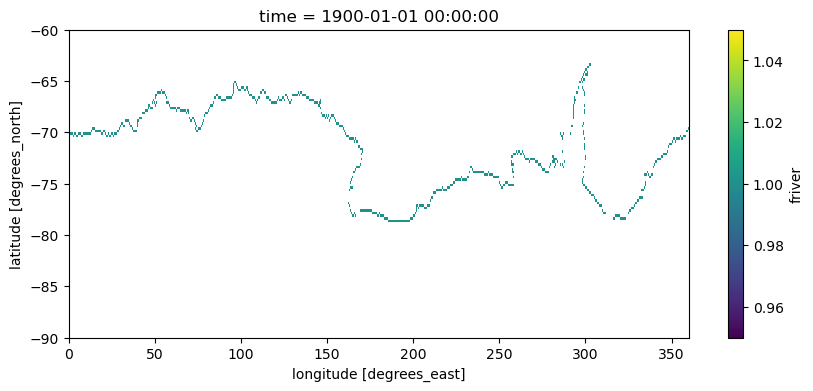

In [32]:
runoff_sv_ref = runoff_sv.friver.sel(latitude=slice(None,-60)).copy(deep=True)
runoff_sv_bool = runoff_sv.friver.sel(latitude=slice(None,-60)).copy(deep=True)
runoff_sv_bool = runoff_sv_bool.where(runoff_sv_bool > 0., np.nan)
runoff_sv_bool = runoff_sv_bool*0+1
runoff_sv_ssp245 = runoff_sv.friver.sel(latitude=slice(None,-60)).copy(deep=True)
runoff_sv_ssp585 = runoff_sv.friver.sel(latitude=slice(None,-60)).copy(deep=True)

runoff_sv_bool.isel(time=0).plot(figsize=(10,4))
plt.show()

In [33]:
def update_runoff(lon_bounds_west, lon_bounds_east, lat_bounds_south, lat_bounds_north):
    
    for i, l in enumerate(lon_bounds_west):
        
        print(i, lon_bounds_west[i])
        r, b, t = lon_bounds_east[i], lat_bounds_south[i], lat_bounds_north[i]
        print(l,r,b,t)
        lon_slice = slice(l,r)
        lat_slice = slice(b,t)
        lon_indices = np.where((runoff_sv_ref.longitude >= l) & (runoff_sv_ref.longitude <= r))[0]
        lat_indices = np.where((runoff_sv_ref.latitude >= b) & (runoff_sv_ref.latitude <= t))[0]
        N_grid_cells = runoff_sv_bool.sel(latitude=lat_slice).sel(longitude=lon_slice).isel(time=0).sum().values

        runoff_sv_ssp585.sel(latitude=lat_slice).sel(longitude=lon_slice).isel(time=-1).plot()
        plt.show()

        #ssp585
        runoff_sv_ssp585[:,lat_indices, lon_indices] = runoff_sv_ref[:,lat_indices, lon_indices] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices]
        #ssp245
        runoff_sv_ssp245[:,lat_indices, lon_indices] = runoff_sv_ref[:,lat_indices, lon_indices] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices]
    
    return runoff_sv_ssp245, runoff_sv_ssp585
    

Apply meltwater fraction to each drainage basin using the bounds and percentages defined earlier in the script. We'll add an extra 30% to the Golledge et al. projections to account for salinity resotirng in the model. 

RFIS (298.0, 324.6, None, -74.5) 34.583
0.07193264 0.018882318000000002
N grid cells: 87.0 From indices: 87.0


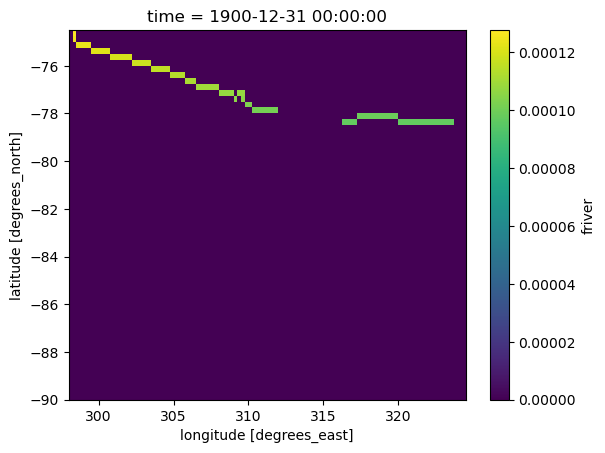

RIS (165.5, 201.6, None, -76.0) 22.478
0.04675424 0.012272988000000002
N grid cells: 136.0 From indices: 136.0


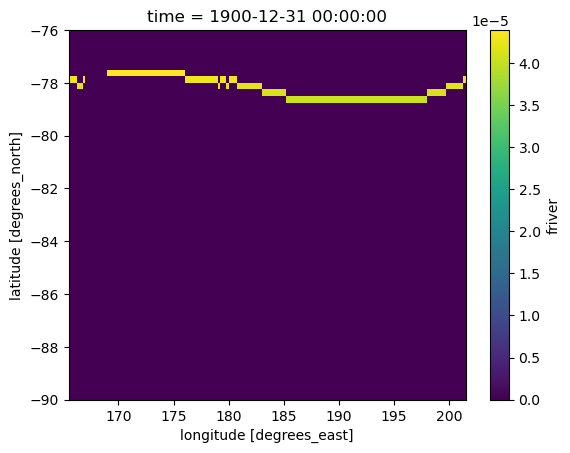

AIS (69.5, 74.4, None, None) 4.609999999999999
0.0095888 0.0025170600000000002
N grid cells: 24.0 From indices: 24.0


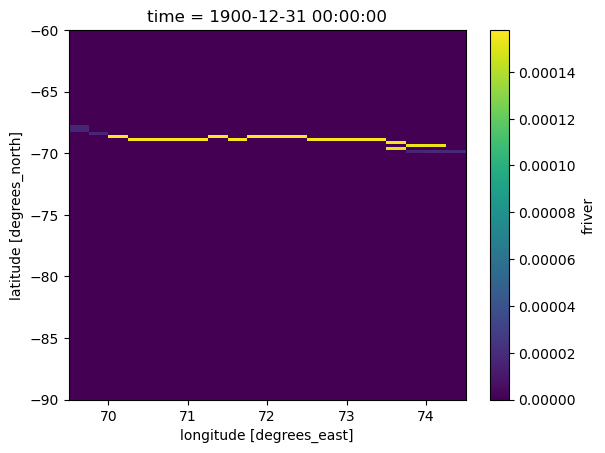

4 (324.6, 350.0, None, None) 4.899
0.010189920000000002 0.0026748540000000004
N grid cells: 113.0 From indices: 113.0


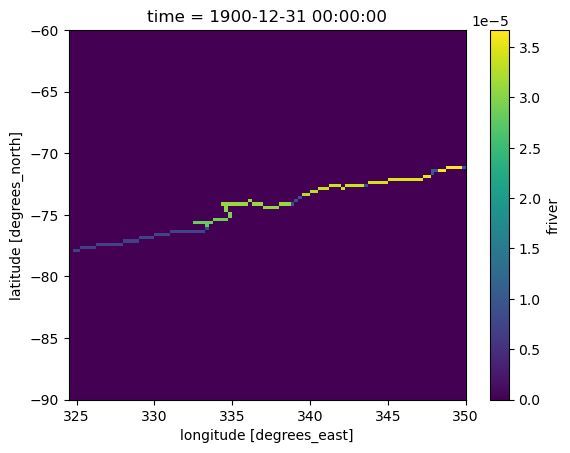

5 (350.0, None, None, None) 1.441
0.0029972800000000006 0.0007867860000000001
5
N grid cells: 50.0 From indices: 50.0


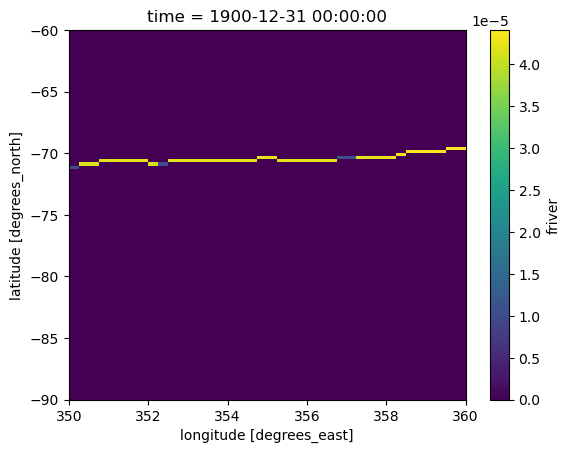

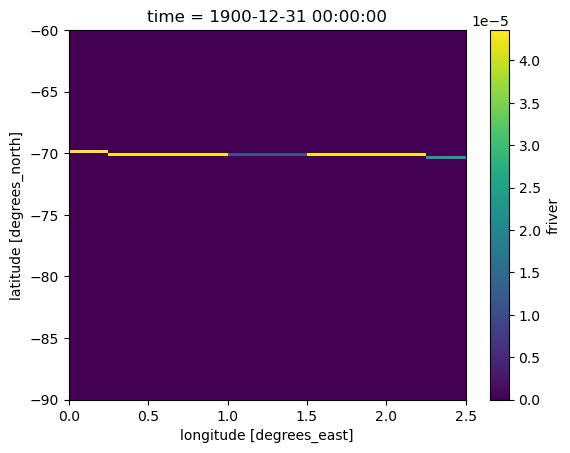

6 (2.5, 34.5, None, None) 1.153
0.0023982400000000003 0.000629538
N grid cells: 129.0 From indices: 129.0


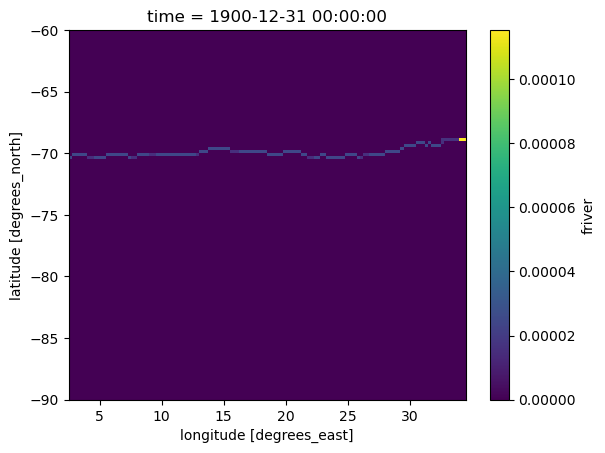

7 (34.5, 56.5, None, None) 0.0
0.0 0.0
N grid cells: 99.0 From indices: 99.0


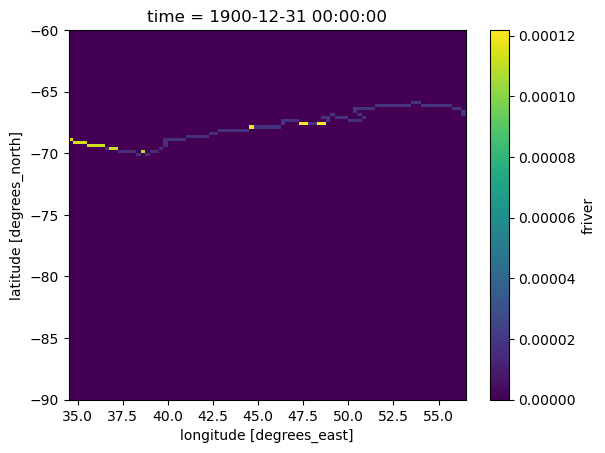

8 (56.5, 69.5, None, None) 0.288
0.00059904 0.000157248
N grid cells: 55.0 From indices: 55.0


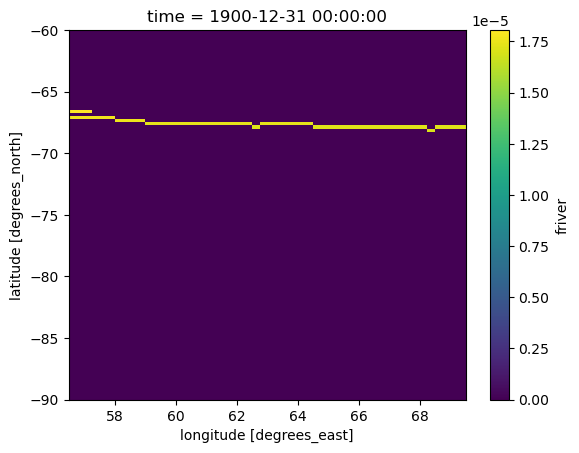

12 (74.4, 105.0, None, None) 0.0
0.0 0.0
N grid cells: 127.0 From indices: 127.0


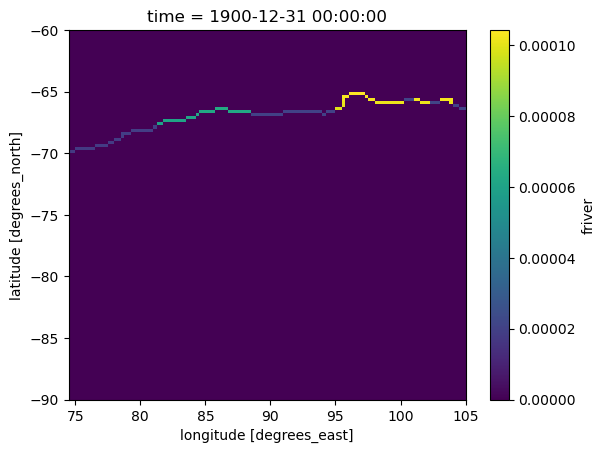

13 (105.0, 130.0, None, None) 2.305
0.004794400000000001 0.0012585300000000001
N grid cells: 101.0 From indices: 101.0


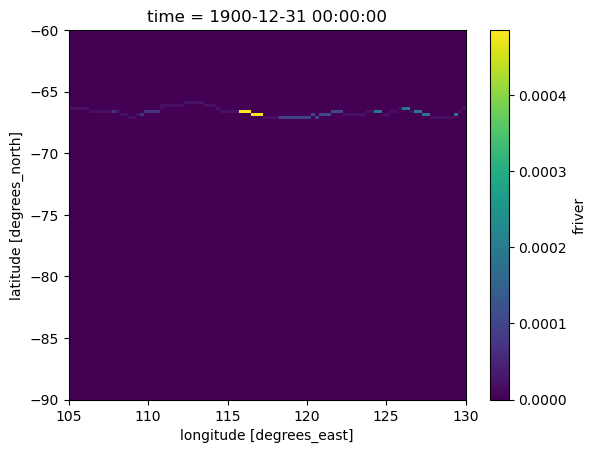

14 (130.0, 158.0, None, None) -0.288
-0.00059904 -0.000157248
N grid cells: 118.0 From indices: 118.0


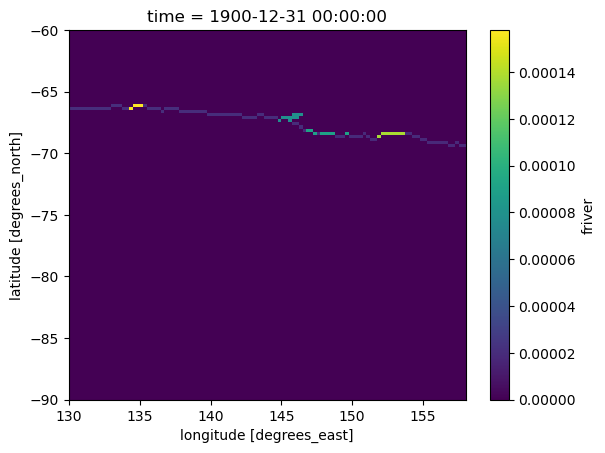

15 (158.0, 173.0, -74.0, -68.0) 0.288
0.00059904 0.000157248
N grid cells: 76.0 From indices: 76.0


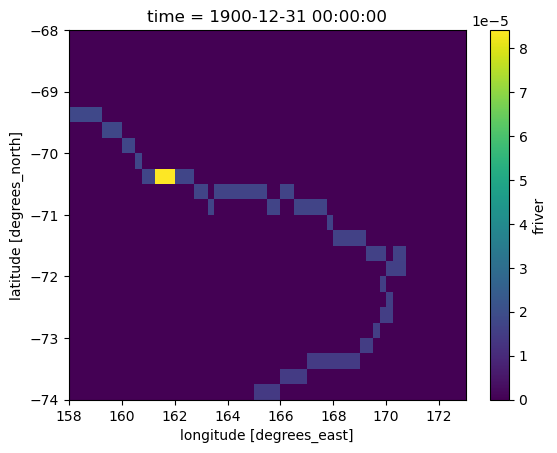

16 (160.0, 165.5, -78.5, -74.0) 0.0
0.0 0.0
N grid cells: 34.0 From indices: 34.0


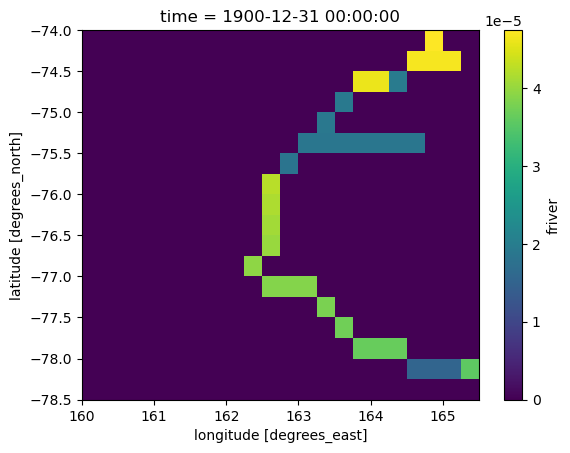

20 (201.6, 245.9, None, None) 5.476
0.01139008 0.002989896
N grid cells: 181.0 From indices: 181.0


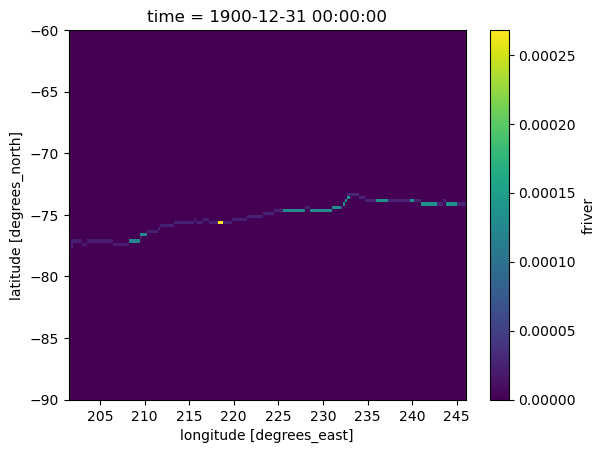

AS (245.9, 260.0, None, -73.75) 15.85
0.032968000000000004 0.008654100000000001
N grid cells: 60.0 From indices: 60.0


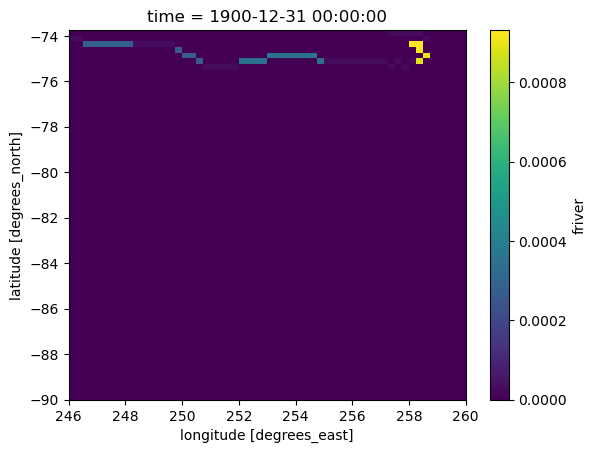

23 (255.0, 279.5, -73.75, None) 1.441
0.0029972800000000006 0.0007867860000000001
23
N grid cells: 106.0 From indices: 106.0


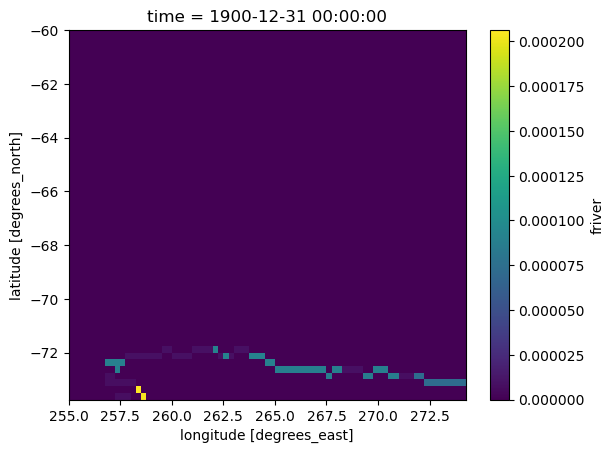

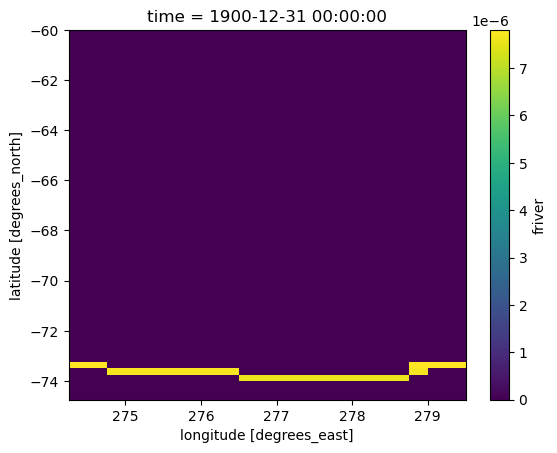

24 (279.5, 291.5, None, -68.0) 1.153
0.0023982400000000003 0.000629538
N grid cells: 54.0 From indices: 54.0


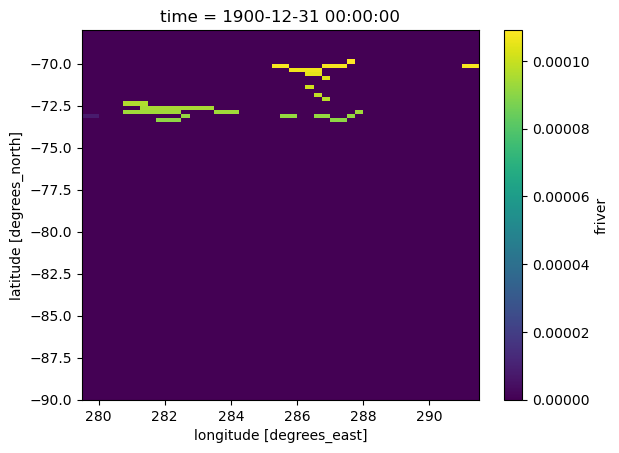

25 (291.5, 302.5, -69.5, None) 0.865
0.0017992 0.00047229000000000005
25
N grid cells: 58.0 From indices: 58.0


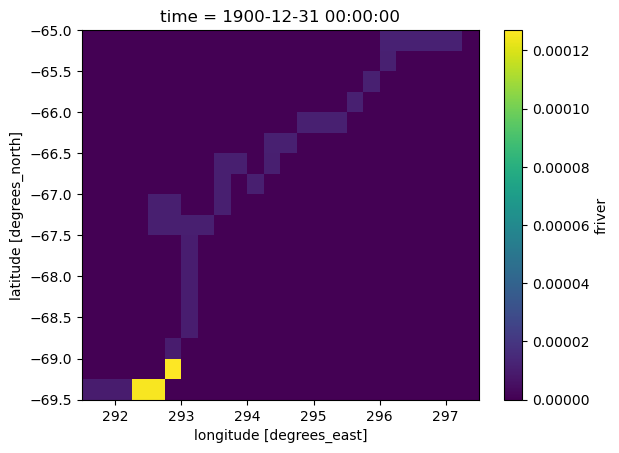

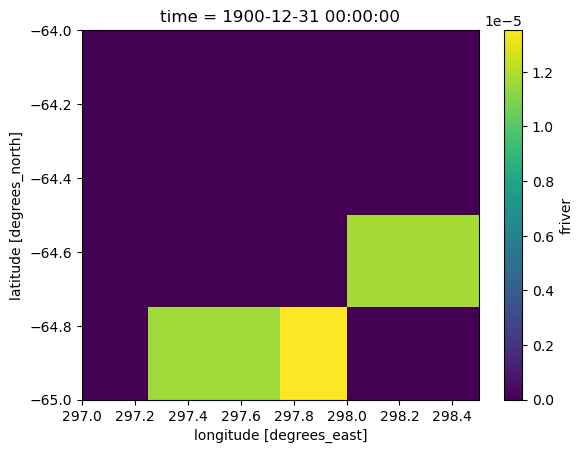

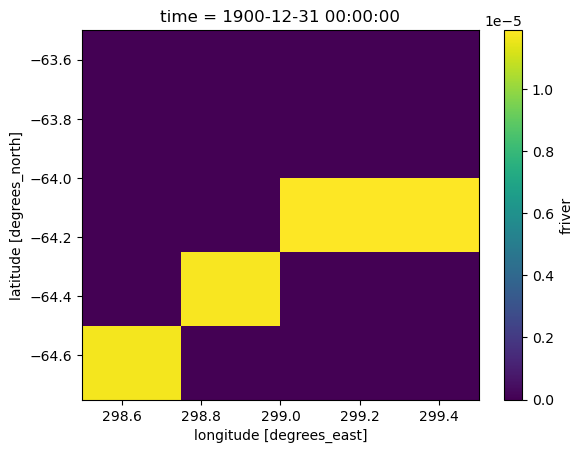

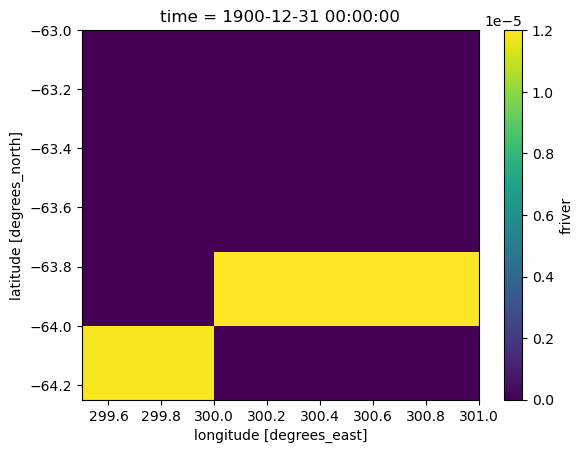

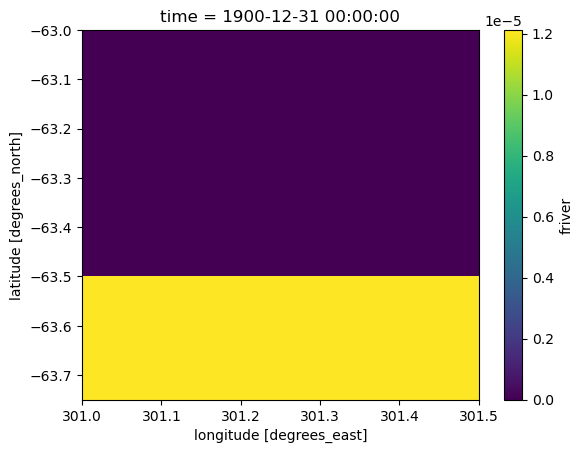

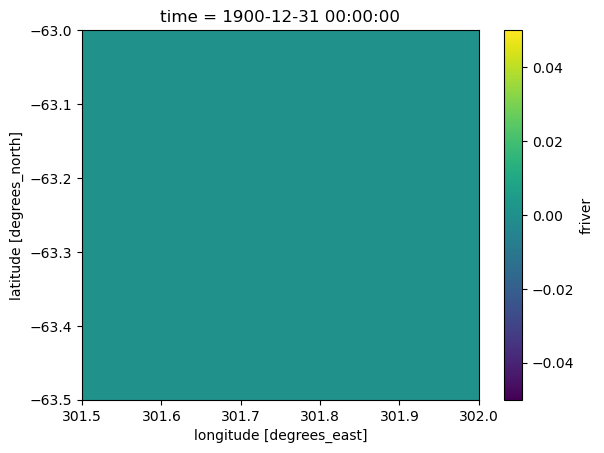

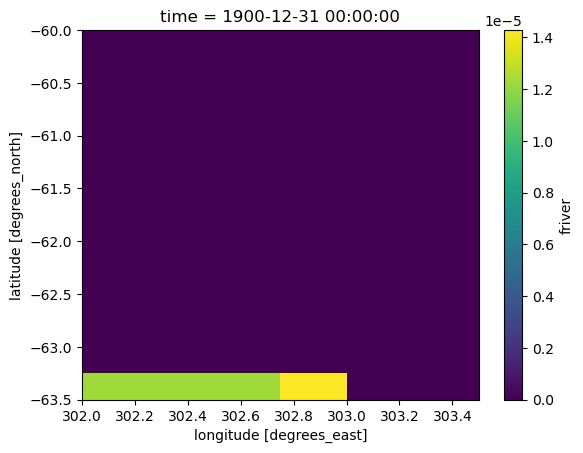

26 (298.0, 306.0, -69.4, -63.5) 3.458
0.00719264 0.0018880680000000001
26
N grid cells: 40.0 From indices: 40.0


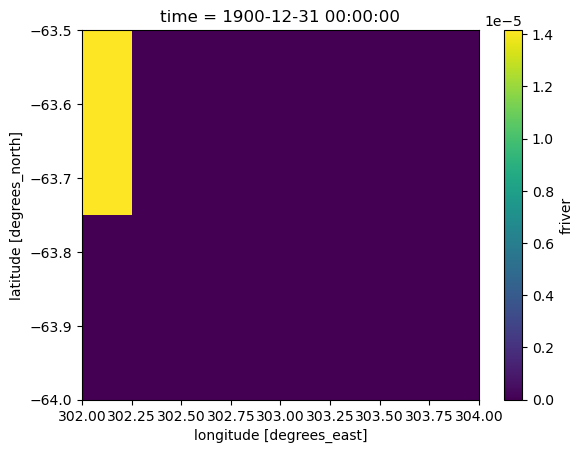

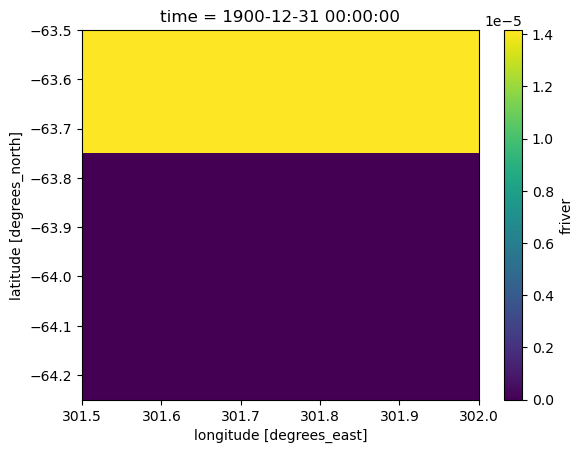

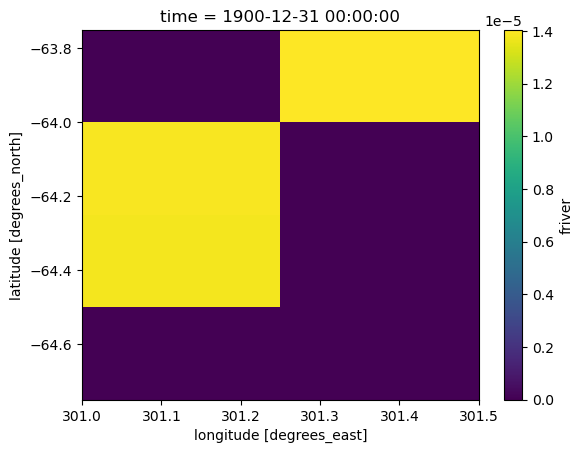

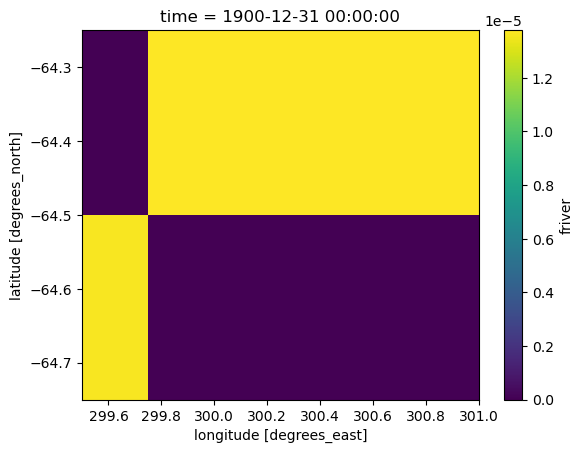

27 (295.0, 303, -74.5, -69.4) 0.0
0.0 0.0
N grid cells: 24.0 From indices: 24.0


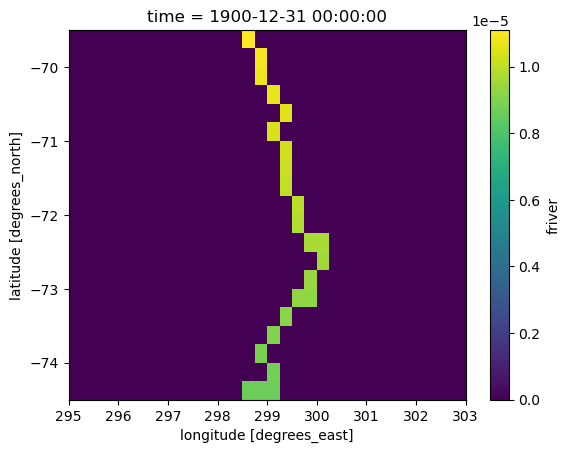

In [34]:
amp = 1.3 # extra 30% to account for salt restoring
rcp85_sv = 0.16
rcp45_sv = 0.042

for key in bounds:
    print(key, bounds[key], mw_frac[key])
    l,r,b,t = bounds[key]
    lat_slice = slice(b,t)
    lon_slice = slice(l,r)

    if t == None:
        t = -60
    if b == None:
        b = -80

    ssp585_sv_addition = 1.3*mw_frac[key]/100.*rcp85_sv
    ssp245_sv_addition = 1.3*mw_frac[key]/100.*rcp45_sv
    print(ssp585_sv_addition, ssp245_sv_addition)

    # region 5 spans the longitude limits of the runoff array. Make sure we're modifying both sections of this region. 
    if key == '5':
        print("5")
        l1, l2 = 350., 0.
        r1, r2 = 360., 2.5
        lon_slice1 = slice(l1, r1)
        lon_slice2 = slice(l2, r2)
        lon_indices1 = np.where((runoff_sv_ref.longitude >= l1) & (runoff_sv_ref.longitude <= r1))[0]
        lon_indices2 = np.where((runoff_sv_ref.longitude >= l2) & (runoff_sv_ref.longitude <= r2))[0]
        lat_indices = np.where((runoff_sv_ref.latitude >= b) & (runoff_sv_ref.latitude <= t))[0]
        N1 = runoff_sv_bool.sel(latitude=lat_slice).sel(longitude=lon_slice1).isel(time=0).sum().values
        N2 = runoff_sv_bool.sel(latitude=lat_slice).sel(longitude=lon_slice2).isel(time=0).sum().values
        N_grid_cells = N1+N2
        N_V2 = runoff_sv_bool[0,lat_indices, lon_indices1].sum().values + runoff_sv_bool[0,lat_indices, lon_indices2].sum().values
        print('N grid cells:',N_grid_cells, 'From indices:',N_V2)
        runoff_sv_ssp585.sel(latitude=lat_slice).sel(longitude=lon_slice1).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice).sel(longitude=lon_slice2).isel(time=-1).plot()
        plt.show()
        #ssp585
        runoff_sv_ssp585[:,lat_indices, lon_indices1] = runoff_sv_ref[:,lat_indices, lon_indices1] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices1]
        runoff_sv_ssp585[:,lat_indices, lon_indices2] = runoff_sv_ref[:,lat_indices, lon_indices2] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices2]
        #ssp245
        runoff_sv_ssp245[:,lat_indices, lon_indices1] = runoff_sv_ref[:,lat_indices, lon_indices1] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices1]
        runoff_sv_ssp245[:,lat_indices, lon_indices2] = runoff_sv_ref[:,lat_indices, lon_indices2] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices2]
    elif key == '23':
        print("23")
        lon_slice1 = slice(l, r-5.3)
        lon_slice2 = slice(r-5.3, r)
        lat_slice1 = slice(b,t)
        lat_slice2 = slice(b-1.,t)
        lon_indices1 = np.where((runoff_sv_ref.longitude >= l) & (runoff_sv_ref.longitude <= r-5.3))[0]
        lon_indices2 = np.where((runoff_sv_ref.longitude >= r-5.3) & (runoff_sv_ref.longitude <= r))[0]
        lat_indices1 = np.where((runoff_sv_ref.latitude >= b) & (runoff_sv_ref.latitude <= t))[0]
        lat_indices2 = np.where((runoff_sv_ref.latitude >= b-1.) & (runoff_sv_ref.latitude <= t))[0]
        N1 = runoff_sv_bool.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=0).sum().values
        N2 = runoff_sv_bool.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=0).sum().values
        N_grid_cells = N1+N2
        N_V2 = runoff_sv_bool[0,lat_indices1, lon_indices1].sum().values + runoff_sv_bool[0,lat_indices2, lon_indices2].sum().values
        print('N grid cells:',N_grid_cells, 'From indices:',N_V2)
        runoff_sv_ssp585.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=-1).plot()
        plt.show()
        #ssp585
        runoff_sv_ssp585[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp585[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
        #ssp245
        runoff_sv_ssp245[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp245[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
    # account for geometry at Peninsula in region 25
    elif key == '25':
        print("25")
        l1,l2,l3,l4,l5,l6,l7 = 291.5, 297., 298.5, 299.5, 301., 301.5, 302.
        r1,r2,r3,r4,r5,r6,r7 = 297.5, 298.5, 299.5, 301., 301.5, 302., 303.5
        b1,b2,b3,b4,b5,b6,b7 = -69.5, -65., -64.75, -64.25, -63.75, -63.6, -63.4
        t1,t2,t3,t4,t5,t6,t7 = -65, -64, -63.5, -63, -63, -63, -60
        lon_slice1, lon_slice2, lon_slice3, lon_slice4, lon_slice5, lon_slice6, lon_slice7 = slice(l1, r1), slice(l2, r2), slice(l3, r3), slice(l4, r4), slice(l5, r5), slice(l6, r6), slice(l7, r7)
        lat_slice1, lat_slice2, lat_slice3, lat_slice4, lat_slice5 ,lat_slice6 ,lat_slice7 = slice(b1, t1), slice(b2, t2), slice(b3, t3), slice(b4, t4), slice(b5, t5), slice(b6, t6), slice(b7, t7)
        lon_indices1 = np.where((runoff_sv_ref.longitude >= l1) & (runoff_sv_ref.longitude <= r1))[0]
        lon_indices2 = np.where((runoff_sv_ref.longitude >= l2) & (runoff_sv_ref.longitude <= r2))[0]
        lon_indices3 = np.where((runoff_sv_ref.longitude >= l3) & (runoff_sv_ref.longitude <= r3))[0]
        lon_indices4 = np.where((runoff_sv_ref.longitude >= l4) & (runoff_sv_ref.longitude <= r4))[0]
        lon_indices5 = np.where((runoff_sv_ref.longitude >= l5) & (runoff_sv_ref.longitude <= r5))[0]
        lon_indices6 = np.where((runoff_sv_ref.longitude >= l6) & (runoff_sv_ref.longitude <= r6))[0]
        lon_indices7 = np.where((runoff_sv_ref.longitude >= l7) & (runoff_sv_ref.longitude <= r7))[0]
        lat_indices1 = np.where((runoff_sv_ref.latitude >= b1) & (runoff_sv_ref.latitude <= t1))[0]
        lat_indices2 = np.where((runoff_sv_ref.latitude >= b2) & (runoff_sv_ref.latitude <= t2))[0]
        lat_indices3 = np.where((runoff_sv_ref.latitude >= b3) & (runoff_sv_ref.latitude <= t3))[0]
        lat_indices4 = np.where((runoff_sv_ref.latitude >= b4) & (runoff_sv_ref.latitude <= t4))[0]
        lat_indices5 = np.where((runoff_sv_ref.latitude >= b5) & (runoff_sv_ref.latitude <= t5))[0]
        lat_indices6 = np.where((runoff_sv_ref.latitude >= b6) & (runoff_sv_ref.latitude <= t6))[0]
        lat_indices7 = np.where((runoff_sv_ref.latitude >= b7) & (runoff_sv_ref.latitude <= t7))[0]
        N1 = runoff_sv_bool.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=0).sum().values
        N2 = runoff_sv_bool.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=0).sum().values
        N3 = runoff_sv_bool.sel(latitude=lat_slice3).sel(longitude=lon_slice3).isel(time=0).sum().values
        N4 = runoff_sv_bool.sel(latitude=lat_slice4).sel(longitude=lon_slice4).isel(time=0).sum().values
        N5 = runoff_sv_bool.sel(latitude=lat_slice5).sel(longitude=lon_slice5).isel(time=0).sum().values
        N6 = runoff_sv_bool.sel(latitude=lat_slice6).sel(longitude=lon_slice6).isel(time=0).sum().values
        N7 = runoff_sv_bool.sel(latitude=lat_slice7).sel(longitude=lon_slice7).isel(time=0).sum().values
        N_grid_cells = N1+N2+N3+N4+N5+N6+N7
        N_V2 = runoff_sv_bool[0,lat_indices1, lon_indices1].sum().values + runoff_sv_bool[0,lat_indices2, lon_indices2].sum().values +\
               runoff_sv_bool[0,lat_indices3, lon_indices3].sum().values + runoff_sv_bool[0,lat_indices4, lon_indices4].sum().values +\
               runoff_sv_bool[0,lat_indices5, lon_indices5].sum().values + runoff_sv_bool[0,lat_indices6, lon_indices6].sum().values +\
               runoff_sv_bool[0,lat_indices7, lon_indices7].sum().values 
        print('N grid cells:',N_grid_cells, 'From indices:',N_V2)
        runoff_sv_ssp585.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice3).sel(longitude=lon_slice3).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice4).sel(longitude=lon_slice4).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice5).sel(longitude=lon_slice5).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice6).sel(longitude=lon_slice6).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice7).sel(longitude=lon_slice7).isel(time=-1).plot()
        plt.show()
        #ssp585
        runoff_sv_ssp585[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp585[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
        runoff_sv_ssp585[:,lat_indices3, lon_indices3] = runoff_sv_ref[:,lat_indices3, lon_indices3] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices3, lon_indices3]
        runoff_sv_ssp585[:,lat_indices4, lon_indices4] = runoff_sv_ref[:,lat_indices4, lon_indices4] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices4, lon_indices4]
        runoff_sv_ssp585[:,lat_indices5, lon_indices5] = runoff_sv_ref[:,lat_indices5, lon_indices5] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices5, lon_indices5]
        runoff_sv_ssp585[:,lat_indices6, lon_indices6] = runoff_sv_ref[:,lat_indices6, lon_indices6] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices6, lon_indices6]
        runoff_sv_ssp585[:,lat_indices7, lon_indices7] = runoff_sv_ref[:,lat_indices7, lon_indices7] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices7, lon_indices7]
        #ssp245
        runoff_sv_ssp245[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp245[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
        runoff_sv_ssp245[:,lat_indices3, lon_indices3] = runoff_sv_ref[:,lat_indices3, lon_indices3] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices3, lon_indices3]
        runoff_sv_ssp245[:,lat_indices4, lon_indices4] = runoff_sv_ref[:,lat_indices4, lon_indices4] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices4, lon_indices4]
        runoff_sv_ssp245[:,lat_indices5, lon_indices5] = runoff_sv_ref[:,lat_indices5, lon_indices5] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices5, lon_indices5]
        runoff_sv_ssp245[:,lat_indices6, lon_indices6] = runoff_sv_ref[:,lat_indices6, lon_indices6] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices6, lon_indices6]
        runoff_sv_ssp245[:,lat_indices7, lon_indices7] = runoff_sv_ref[:,lat_indices7, lon_indices7] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices7, lon_indices7]
    # account for geometry at Peninsula in region 26
    elif key == '26':
        print("26")
        l1,l2,l3,l4,l5,l6 = 302., 301.5, 301., 299.5, 298.5, 297.5
        r1,r2,r3,r4,r5,r6 = 304., 302., 301.5, 301., 300.5, 301.5
        b1,b2,b3,b4,b5,b6 = -64., -64.25, -64.75, -64.75, -65.25, -69.4
        t1,t2,t3,t4,t5,t6 = -63.4, -63.6, -63.75, -64.25, -64.75, -65.
        lon_slice1, lon_slice2, lon_slice3, lon_slice4, lon_slice5, lon_slice6 = slice(l1, r1), slice(l2, r2), slice(l3, r3), slice(l4, r4), slice(l5, r5), slice(l6, r6)
        lat_slice1, lat_slice2, lat_slice3, lat_slice4, lat_slice5 ,lat_slice6 = slice(b1, t1), slice(b2, t2), slice(b3, t3), slice(b4, t4), slice(b5, t5), slice(b6, t6)
        lon_indices1 = np.where((runoff_sv_ref.longitude >= l1) & (runoff_sv_ref.longitude <= r1))[0]
        lon_indices2 = np.where((runoff_sv_ref.longitude >= l2) & (runoff_sv_ref.longitude <= r2))[0]
        lon_indices3 = np.where((runoff_sv_ref.longitude >= l3) & (runoff_sv_ref.longitude <= r3))[0]
        lon_indices4 = np.where((runoff_sv_ref.longitude >= l4) & (runoff_sv_ref.longitude <= r4))[0]
        lon_indices5 = np.where((runoff_sv_ref.longitude >= l5) & (runoff_sv_ref.longitude <= r5))[0]
        lon_indices6 = np.where((runoff_sv_ref.longitude >= l6) & (runoff_sv_ref.longitude <= r6))[0]
        lat_indices1 = np.where((runoff_sv_ref.latitude >= b1) & (runoff_sv_ref.latitude <= t1))[0]
        lat_indices2 = np.where((runoff_sv_ref.latitude >= b2) & (runoff_sv_ref.latitude <= t2))[0]
        lat_indices3 = np.where((runoff_sv_ref.latitude >= b3) & (runoff_sv_ref.latitude <= t3))[0]
        lat_indices4 = np.where((runoff_sv_ref.latitude >= b4) & (runoff_sv_ref.latitude <= t4))[0]
        lat_indices5 = np.where((runoff_sv_ref.latitude >= b5) & (runoff_sv_ref.latitude <= t5))[0]
        lat_indices6 = np.where((runoff_sv_ref.latitude >= b6) & (runoff_sv_ref.latitude <= t6))[0]
        N1 = runoff_sv_bool.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=0).sum().values
        N2 = runoff_sv_bool.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=0).sum().values
        N3 = runoff_sv_bool.sel(latitude=lat_slice3).sel(longitude=lon_slice3).isel(time=0).sum().values
        N4 = runoff_sv_bool.sel(latitude=lat_slice4).sel(longitude=lon_slice4).isel(time=0).sum().values
        N5 = runoff_sv_bool.sel(latitude=lat_slice5).sel(longitude=lon_slice5).isel(time=0).sum().values
        N6 = runoff_sv_bool.sel(latitude=lat_slice6).sel(longitude=lon_slice6).isel(time=0).sum().values
        N_grid_cells = N1+N2+N3+N4+N5+N6
        N_V2 = runoff_sv_bool[0,lat_indices1, lon_indices1].sum().values + runoff_sv_bool[0,lat_indices2, lon_indices2].sum().values +\
               runoff_sv_bool[0,lat_indices3, lon_indices3].sum().values + runoff_sv_bool[0,lat_indices4, lon_indices4].sum().values +\
               runoff_sv_bool[0,lat_indices5, lon_indices5].sum().values + runoff_sv_bool[0,lat_indices6, lon_indices6].sum().values 
        print('N grid cells:',N_grid_cells, 'From indices:',N_V2)
        runoff_sv_ssp585.sel(latitude=lat_slice1).sel(longitude=lon_slice1).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice2).sel(longitude=lon_slice2).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice3).sel(longitude=lon_slice3).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585.sel(latitude=lat_slice4).sel(longitude=lon_slice4).isel(time=-1).plot()
        plt.show()
        #ssp585
        runoff_sv_ssp585[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp585[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
        runoff_sv_ssp585[:,lat_indices3, lon_indices3] = runoff_sv_ref[:,lat_indices3, lon_indices3] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices3, lon_indices3]
        runoff_sv_ssp585[:,lat_indices4, lon_indices4] = runoff_sv_ref[:,lat_indices4, lon_indices4] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices4, lon_indices4]
        runoff_sv_ssp585[:,lat_indices5, lon_indices5] = runoff_sv_ref[:,lat_indices5, lon_indices5] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices5, lon_indices5]
        runoff_sv_ssp585[:,lat_indices6, lon_indices6] = runoff_sv_ref[:,lat_indices6, lon_indices6] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices6, lon_indices6]
        #ssp245
        runoff_sv_ssp245[:,lat_indices1, lon_indices1] = runoff_sv_ref[:,lat_indices1, lon_indices1] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices1, lon_indices1]
        runoff_sv_ssp245[:,lat_indices2, lon_indices2] = runoff_sv_ref[:,lat_indices2, lon_indices2] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices2, lon_indices2]
        runoff_sv_ssp245[:,lat_indices3, lon_indices3] = runoff_sv_ref[:,lat_indices3, lon_indices3] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices3, lon_indices3]
        runoff_sv_ssp245[:,lat_indices4, lon_indices4] = runoff_sv_ref[:,lat_indices4, lon_indices4] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices4, lon_indices4]
        runoff_sv_ssp245[:,lat_indices5, lon_indices5] = runoff_sv_ref[:,lat_indices5, lon_indices5] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices5, lon_indices5]
        runoff_sv_ssp245[:,lat_indices6, lon_indices6] = runoff_sv_ref[:,lat_indices6, lon_indices6] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices6, lon_indices6]
    else:
        lon_indices = np.where((runoff_sv_ref.longitude >= l) & (runoff_sv_ref.longitude <= r))[0]
        lat_indices = np.where((runoff_sv_ref.latitude >= b) & (runoff_sv_ref.latitude <= t))[0]
        N_grid_cells = runoff_sv_bool.sel(latitude=lat_slice).sel(longitude=lon_slice).isel(time=0).sum().values
        print('N grid cells:',N_grid_cells, 'From indices:',runoff_sv_bool[0,lat_indices, lon_indices].sum().values)
        runoff_sv_ssp585.sel(latitude=lat_slice).sel(longitude=lon_slice).isel(time=-1).plot()
        plt.show()
        runoff_sv_ssp585[:,lat_indices, lon_indices] = runoff_sv_ref[:,lat_indices, lon_indices] + ssp585_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices]
        runoff_sv_ssp245[:,lat_indices, lon_indices] = runoff_sv_ref[:,lat_indices, lon_indices] + ssp245_sv_addition/N_grid_cells*runoff_sv_bool[:,lat_indices, lon_indices]

# fill NaNs with zero
runoff_sv_ssp585 = runoff_sv_ssp585.fillna(0.)
runoff_sv_ssp245 = runoff_sv_ssp245.fillna(0.)

Check that our runoff values match with the expected projections.

In [35]:
print("Theoretical SSP585 circum-Antarctic freshwater flux in Sv", runoff_sv_ref.sum(dim=['latitude','longitude']).isel(time=0).values + 1.3*0.16)
print("Calculated SSP585 circum-Antarctic freshwater flux in Sv", runoff_sv_ssp585.fillna(0.).sum(dim=['latitude','longitude']).isel(time=0).values)

print("Theoretical SSP245 circum-Antarctic freshwater flux in Sv", runoff_sv_ref.sum(dim=['latitude','longitude']).isel(time=0).values + 1.3*0.042)
print("Calculated SSP245 circum-Antarctic freshwater flux in Sv", runoff_sv_ssp245.fillna(0.).sum(dim=['latitude','longitude']).isel(time=0).values)

Theoretical SSP585 circum-Antarctic freshwater flux in Sv 0.2954600947523117
Calculated SSP585 circum-Antarctic freshwater flux in Sv 0.2954600947523117
Theoretical SSP245 circum-Antarctic freshwater flux in Sv 0.1420600947523117
Calculated SSP245 circum-Antarctic freshwater flux in Sv 0.14206009475231168


Plot the differences between the calculated and theoretical freshwater flux addition. 

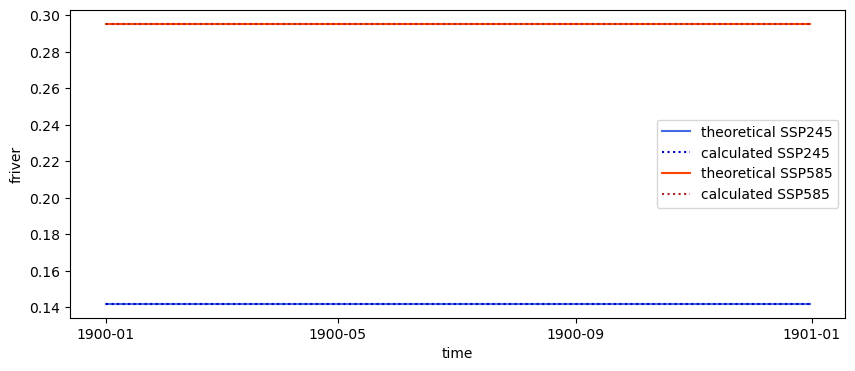

In [36]:
(runoff_sv_ref.sum(dim=['latitude','longitude']) + 1.3*0.042).plot(c='royalblue',label='theoretical SSP245', figsize=(10,4))
(runoff_sv_ssp245.sum(dim=['latitude','longitude'])).plot(c='mediumblue',label='calculated SSP245', ls=':')
(runoff_sv_ref.sum(dim=['latitude','longitude']) + 1.3*0.16).plot(c='orangered',label='theoretical SSP585')
(runoff_sv_ssp585.sum(dim=['latitude','longitude'])).plot(c='firebrick',label='calculated SSP585', ls=':')
plt.legend()
plt.show()

Plot these fluxes as a function of longitude. 

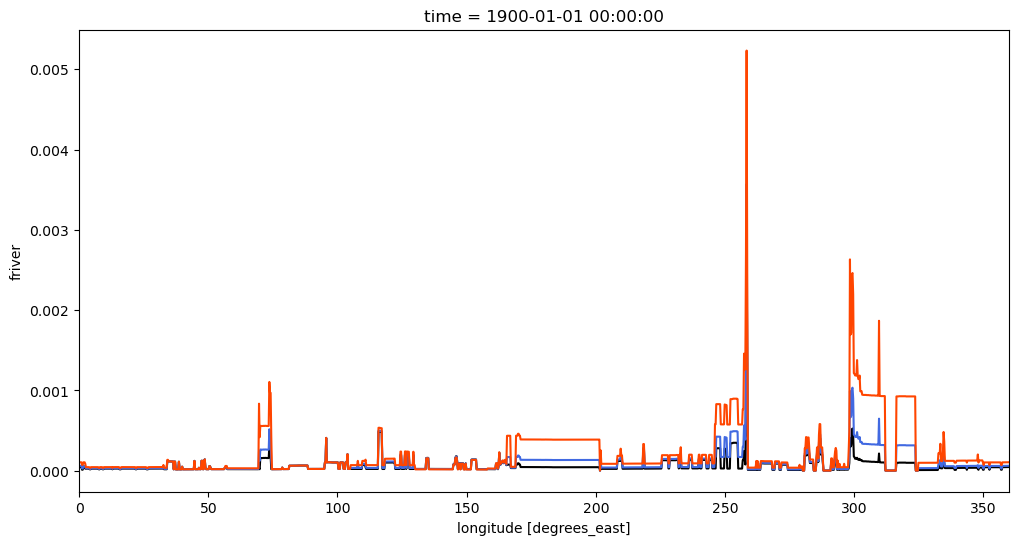

In [38]:
runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='k', label='CNTL', figsize=(12,6))
runoff_sv_ssp245.isel(time=0).sum(dim='latitude').plot(c='royalblue', label='SSP245')
runoff_sv_ssp585.isel(time=0).sum(dim='latitude').plot(c='orangered', label='SSP585')
plt.xlim([0,360])
plt.show()

Plot the difference in runoff as a function of longitude (to check that we are indeed applying a spatially varying pattern of meltwater). 

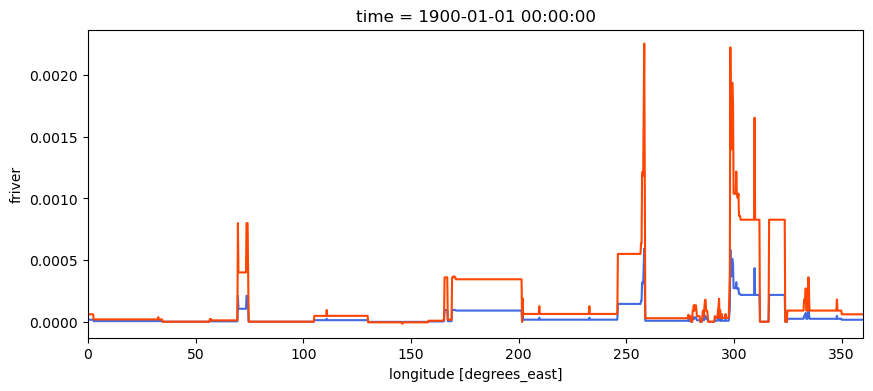

In [39]:
(runoff_sv_ssp245.isel(time=0).sum(dim='latitude') - runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude')).plot(c='royalblue', label='SSP245 difference with CNTL', figsize=(10,4))
(runoff_sv_ssp585.isel(time=0).sum(dim='latitude') - runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude')).plot(c='orangered', label='SSP585 difference with CNTL')
plt.xlim([0,360])
plt.show()

Now update the global runoff fields with these Antarctic freshwater fluxes. 

In [62]:
#SSP585
runoff_global_ssp585_sv = runoff_sv.copy(deep=True)
lat_indices = np.where(runoff_sv.latitude <= -60)[0]
runoff_global_ssp585_sv['friver'][:,lat_indices,:] = runoff_sv_ssp585.values

#SSP245
runoff_global_ssp245_sv = runoff_sv.copy(deep=True)
lat_indices = np.where(runoff_sv.latitude <= -60)[0]
runoff_global_ssp245_sv['friver'][:,lat_indices,:] = runoff_sv_ssp245.values

In [63]:
runoff_global_ssp245_sv

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33

In [64]:
runoff_global_ssp585_sv

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33

Check that the values in the global fields exactly match the values in the Antarctic only array (difference should be zero). 

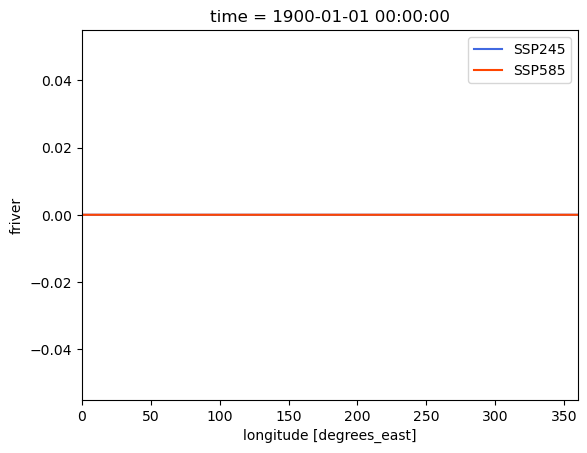

In [65]:
#runoff_sv.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='k', label='CNTL', figsize=(12,6))
(runoff_global_ssp245_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude') - \
     runoff_sv_ssp245.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude')).plot(c='royalblue', label='SSP245')
(runoff_global_ssp585_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude') - \
     runoff_sv_ssp585.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude')).plot(c='orangered', label='SSP585')
plt.xlim([0,360])
plt.legend()
plt.show()

Plot the longitudinal distribution. 

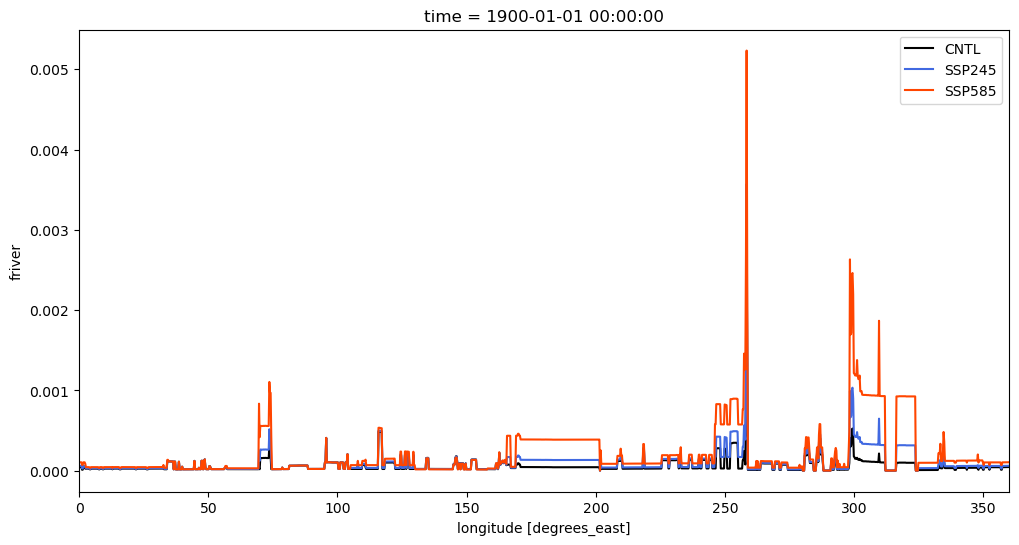

In [66]:
runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='k', label='CNTL', figsize=(12,6))
runoff_global_ssp245_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='royalblue', label='SSP245')
runoff_global_ssp585_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='orangered', label='SSP585')
plt.xlim([0,360])
plt.legend()
plt.show()

Check that runoff is reduced in regions we want it to be (basin 14 has a small net positive flux in 2100). 

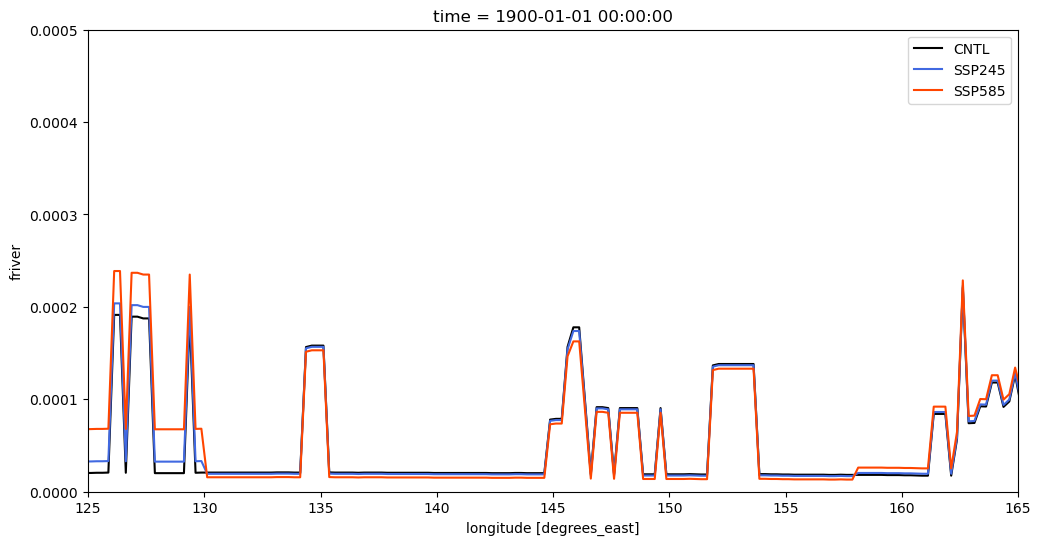

In [67]:
runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='k', label='CNTL', figsize=(12,6))
runoff_global_ssp245_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='royalblue', label='SSP245')
runoff_global_ssp585_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).sum(dim='latitude').plot(c='orangered', label='SSP585')
plt.xlim([125,165])
plt.ylim([0,0.0005])
plt.legend()
plt.show()

Plot a map showing spatial distribution of perturbation. 

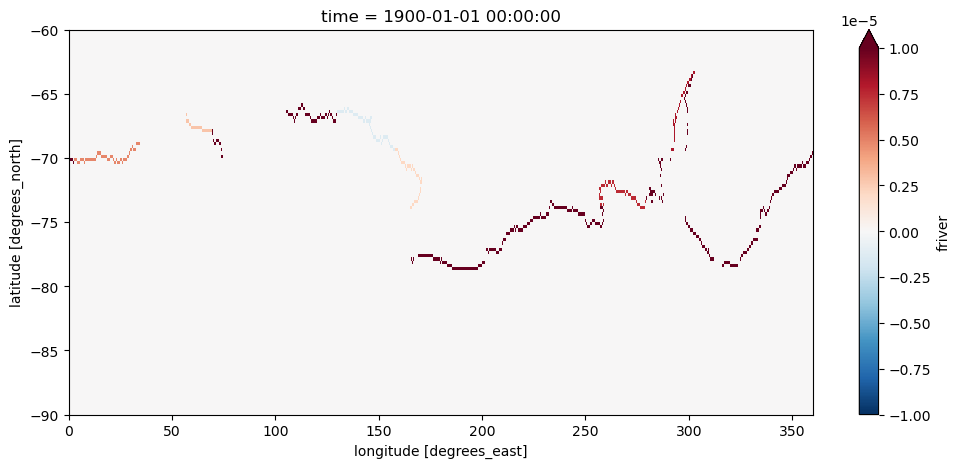

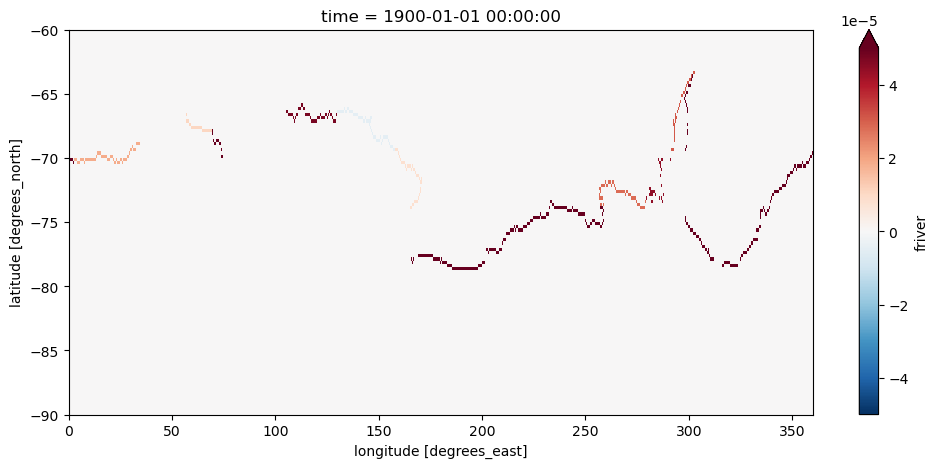

In [68]:
#SSP245
(runoff_global_ssp245_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).fillna(0.) - \
     runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0)).plot(vmin=-0.00001, vmax=0.00001, cmap='RdBu_r', figsize=(12,5))

plt.show()

#SSP585
(runoff_global_ssp585_sv.friver.sel(latitude=slice(None, -60)).isel(time=0).fillna(0.) - \
     runoff_sv.friver.sel(latitude=slice(None, -60)).isel(time=0)).plot(vmin=-0.00005, vmax=0.00005, cmap='RdBu_r', figsize=(12,5))

plt.show()

Plot difference between control and this added meltwater as a function of time. 

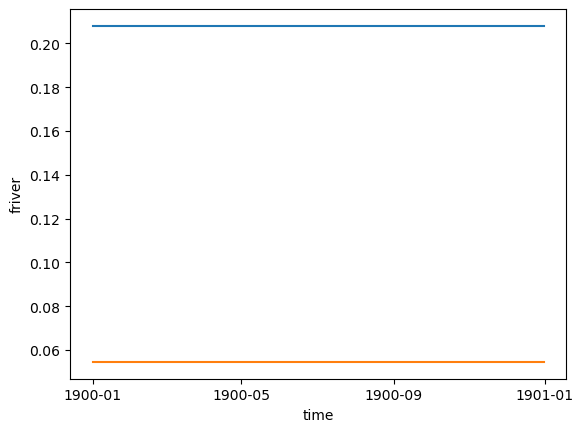

In [69]:
(runoff_global_ssp585_sv.friver.sel(latitude=slice(None, -60)).sum(dim=['latitude','longitude' ]) - runoff_sv.friver.sel(latitude=slice(None, -60)).sum(dim=['latitude','longitude'])).plot()
(runoff_global_ssp245_sv.friver.sel(latitude=slice(None, -60)).sum(dim=['latitude','longitude' ]) - runoff_sv.friver.sel(latitude=slice(None, -60)).sum(dim=['latitude','longitude'])).plot()

plt.show()

Now convert back into units of $kg/m^2/s$

In [78]:
runoff_global_ssp245 = runoff.copy(deep=True)
runoff_global_ssp585 = runoff.copy(deep=True)
runoff_global_ssp245['friver'] = (runoff_global_ssp245_sv.friver*1000000*1000)/area
runoff_global_ssp585['friver'] = (runoff_global_ssp585_sv.friver*1000000*1000)/area
runoff_global_ssp585.friver.attrs['units'] = 'kg/m2/sec'
runoff_global_ssp585.friver.attrs['long_name'] = 'Water flux into sea water from rivers'
runoff_global_ssp585.friver.attrs['standard_name'] = 'water_flux_into_sea_water_from_rivers'
runoff_global_ssp245.friver.attrs['units'] = 'kg/m2/sec'
runoff_global_ssp245.friver.attrs['long_name'] = 'Water flux into sea water from rivers'
runoff_global_ssp245.friver.attrs['standard_name'] = 'water_flux_into_sea_water_from_rivers'

In [50]:
runoff_global_ssp245 = (runoff_global_ssp245_sv*1000000*1000)/area
runoff_global_ssp585 = (runoff_global_ssp585_sv*1000000*1000)/area

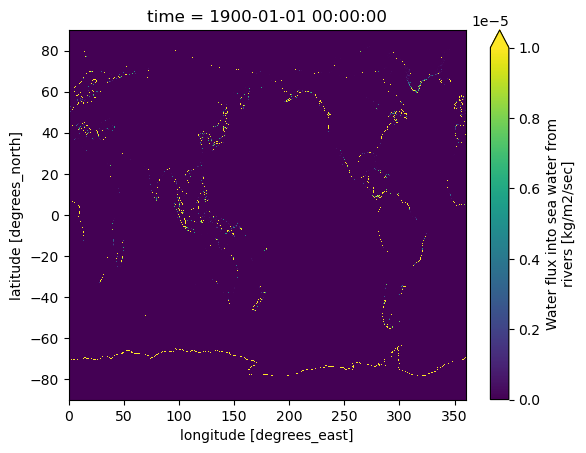

In [81]:
runoff_global_ssp585.friver.isel(time=0).plot(vmax=0.00001)
plt.show()

Plot the spatial difference between control and SSP245 and SSP585. Only changes should be around the Antarctic margin. 

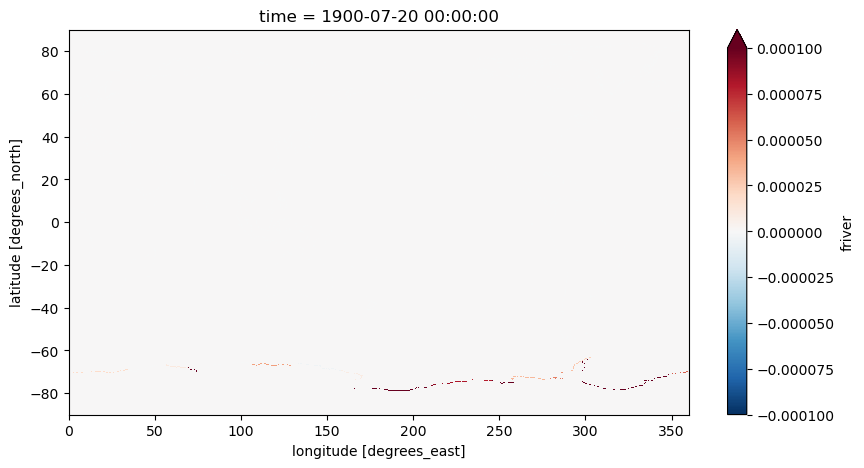

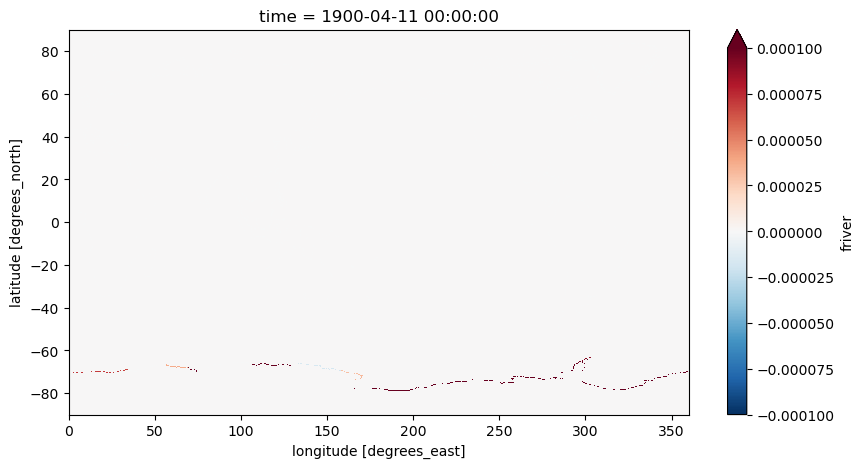

In [86]:
# SSP245
(runoff_global_ssp245.friver.isel(time=200) - runoff.friver.isel(time=200)).plot(vmin=-0.0001, vmax=0.0001, cmap='RdBu_r', figsize=(10,5))
plt.show()

# SSP585
(runoff_global_ssp585.friver.isel(time=100) - runoff.friver.isel(time=100)).plot(vmin=-0.0001, vmax=0.0001, cmap='RdBu_r', figsize=(10,5))
plt.show()

Save to file for use in simulations. 

In [87]:
outdir_ssp245 = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp245_mw/'
outdir_ssp585 = '/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp585_mw/'
file_ssp245 = 'RYF.runoff_all.1990_1991.nc'
file_ssp585 = 'RYF.runoff_all.1990_1991.nc'
print(f'Saving to {outdir_ssp245 + file_ssp245}')
runoff_global_ssp245.to_netcdf(outdir_ssp245 + file_ssp245)
print(f'Saving to {outdir_ssp585 + file_ssp585}')
runoff_global_ssp585.to_netcdf(outdir_ssp585 + file_ssp585)

Saving to /g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp245_mw/RYF.runoff_all.1990_1991.nc
Saving to /g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/JRA55-do_input_files/ssp585_mw/RYF.runoff_all.1990_1991.nc
